## 3.2. Modelos Estatísticos para Séries Temporais

**"Todos os modelos estão errados, mas alguns são úteis" (George Box)**

Em 1970 os estatísticos George Box e Gwilym Jenkins propuseram uma abordagem à modelagem de séries temporais (**Box-Jenkins Method**) que consiste nos seguintes steps:<br>

1. Identificação do modelo e seleção do modelo: certificando-se de que as variáveis são **estacionárias**(caso não sejam, efetuar transformação para alcançar a estacionariedade), identificar **sazonalidade** na série e usar gráficos das funções de autocorrelação (**ACF**) e autocorrelação parcial (**PACF**) para decidir qual (se houver) **componente autorregressivo** ou de **média móvel** deve ser usado no modelo. <br>
<br>
2. Estimação de parâmetros usando algoritmos de computação para chegar aos **coeficientes** que melhor se ajustam ao modelo **ARIMA** selecionado. Os métodos mais comuns usam **estimativa de máxima verossimilhança** ou **estimativa não linear de mínimos quadrados**. <br>
<br>
3. Verificação do modelo estatístico testando se o modelo estimado está de acordo com as especificações de um processo **univariado estacionário**. Em particular, os **resíduos devem ser independentes** uns dos outros e **constantes em média e variância** ao longo do tempo. (Traçar a média e a variância dos resíduos ao longo do tempo e realizar um teste de **Ljung-Box** ou traçar a **autocorrelação** e a **autocorrelação parcial** dos resíduos são úteis para identificar **erros de especificação**.) Se a estimativa for inadequada, temos que retornar ao primeiro passo e tentar construir um modelo melhor.

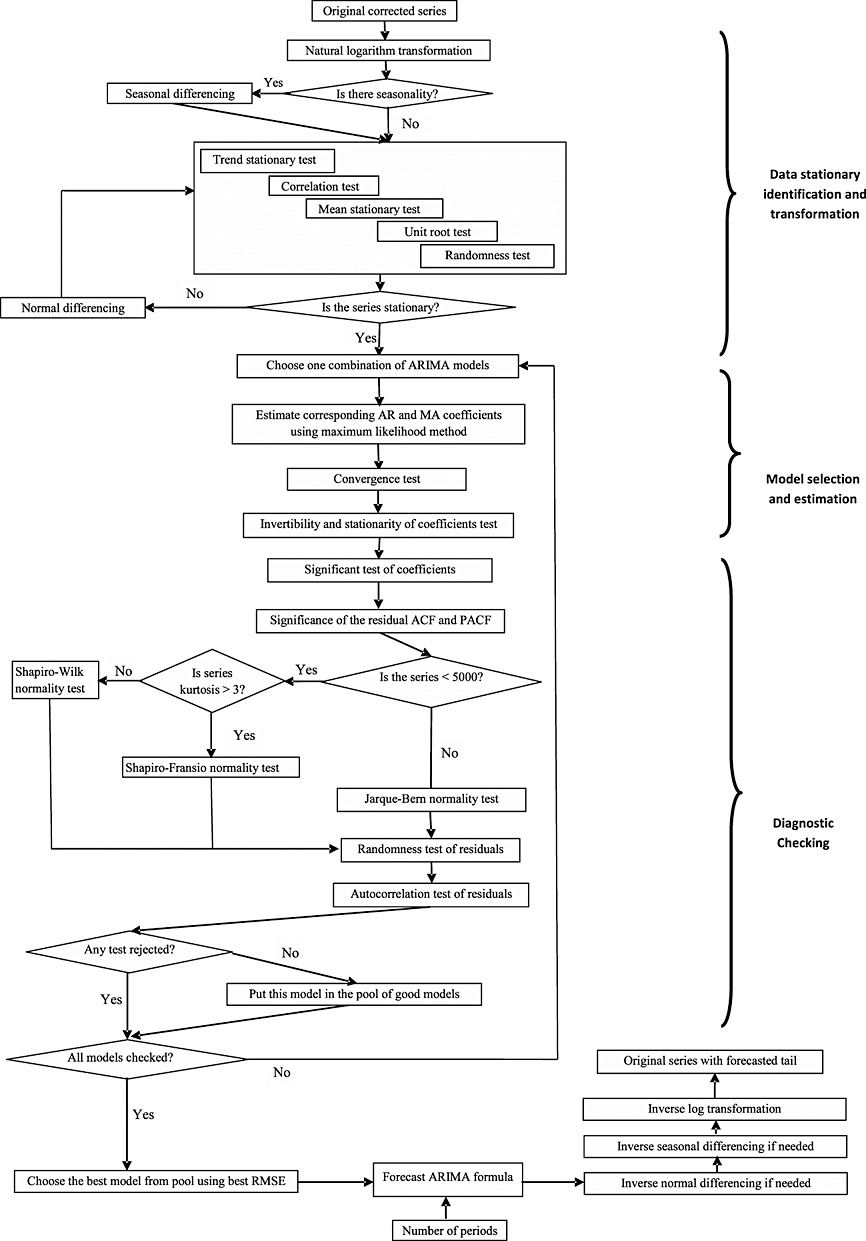

Neste exemplo vamos reduzir os steps da imagem acima optando por uma abordagem mais simples e didática.<br>

**A saber:** <br>

Os modelos mais comuns na abordagem de séries temporais são:<br>

- Modelos autorregressivos - **AR(p)** <br>
- Modelos de média móvel - **MA(q)**
- Modelos autorregressivos de média móvel - **ARMA(p,q)**
- Modelos autorregressivos integrados de média móvel - **ARIMA(p,d,q)** <br>
- Modelos autorregressivos integrados de média móvel com sazonalidade - **SARIMA(p,d,q)(P,D,Q,s)** <br>
- Modelos autorregressivos integrados de média móvel com sazonalidade e variável exógena - **SARIMAX(p,d,q)x(P,D,Q,s)**
- Autorregressão vetorial - **VAR** <br>
- Modelos hieráquicos <br>



Para calcular **MA, AR, ARMA** e **ARIMA** vamos usar a mesma função **ARIMA** de **statsmodels**, uma vez que: <br>

**ARIMA(p,d,q)**<br>
**AR(p) = ARIMA(p,0,0)** <br>
**MA(q) = ARIMA(0,0,q)** <br>
**ARMA(p,q) = ARIMA(p,0,q)**

**OBS:** p, q e d são os hiperparâmetros do modelo.

<font color='red'>**Importante!**

**Por que não usar regressão linear?** A **regressão linear presume que os dados sejam independentes e identicamente distribuídos**. Isso não ocorre tão comumente em séries temporais porque os pontos próximos no tempo **costumam estar fortemente relacionados uns com os outros**. Na verdade, **quando não há correlações temporais, não se pode utilizar a série temporal para predizer o futuro ou compreender a dinâmica temporal**. <br>

**Para que a regressão linear possa ser aplicada a uma série temporal é necessário que as seguintes condições sejam atendidas:**<br>

- A série temporal tem uma resposta linear aos seus preditores;<br>
- Nenhuma variável de entrada é constante ao longo do tempo ou perfeitamente correlacionada com outra variável de entrada;<br>
- O valor esperado do erro deve ser sempre 0; <br>
- Não deve existir correlação entre os erros; <br>
- A variância do erro independe do tempo. <br>

**Se essas suposições forem válidas o método de regressão dos mínimos quadrados ordinários** é um estimador não viesado do coeficientes dados às entradas, mesmo para dados de séries temporais. **Porém se não forem válidas e você utilizar uma regressão linear em uma série temporal que não atenda às suposições acima:**<br>

- Seus coeficientes não minimizarão o erro do seu modelo;<br>
- Seus *p-valores* na avaliação de significância estatística em um teste provavelmente estarão incorretos.

## STEP 1. Identificação de Estacionariedade

Vamos começar explorando a função **ARIMA** plotando diferentes gráficos conforme a alteração dos **hiperparâmetros**.

In [1]:
from datetime import datetime
import numpy as np             
import pandas as pd            
import matplotlib.pylab as plt 
%matplotlib inline             
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

In [2]:
dataset = pd.read_csv('AirPassengers.csv')
dataset['Month'] = pd.to_datetime(dataset['Month'],infer_datetime_format=True) #convert from string to datetime
indexedDataset = dataset.set_index(['Month'])
indexedDataset.head(5)

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


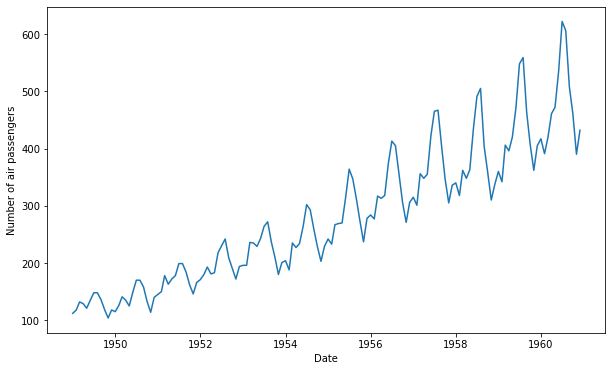

In [3]:
## plot graph
plt.xlabel('Date')
plt.ylabel('Number of air passengers')
plt.plot(indexedDataset)

In [4]:
#Determine rolling statistics
rolmean = indexedDataset.rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
rolstd = indexedDataset.rolling(window=12).std()
print(rolmean,rolstd)

            Passengers
Month                 
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
...                ...
1960-08-01  463.333333
1960-09-01  467.083333
1960-10-01  471.583333
1960-11-01  473.916667
1960-12-01  476.166667

[144 rows x 1 columns]             Passengers
Month                 
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
...                ...
1960-08-01   83.630500
1960-09-01   84.617276
1960-10-01   82.541954
1960-11-01   79.502382
1960-12-01   77.737125

[144 rows x 1 columns]


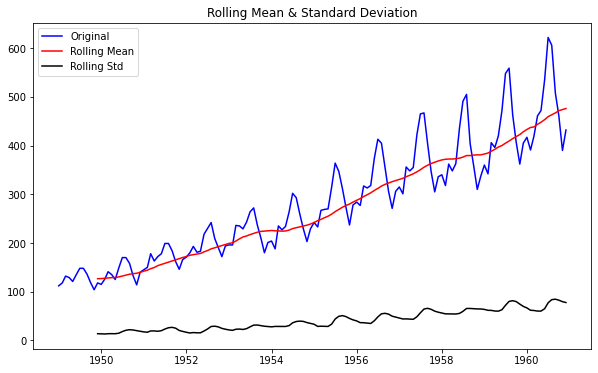

In [5]:
#Calculando média móvel e desvio padrão ao longo do tempo
orig = plt.plot(indexedDataset, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

**Série é estacionária?** Analisando o gráfico, **não**.<br>
<br>
No gráfico acima, vemos que a **média móvel** tem um componente de **tendência**. <br>
Para que nossa série temporal seja estacionária, precisamos garantir que ambas as estatísticas "móveis", média e desvio padrão, sejam constantes, as linhas de plotagem para ambos têm que ser paralelas ao eixo x.
<br>
Para comprovar que a hipótese de que a série temporal **não é estacionária**, vamos realizar o teste **ADCF**.

In [6]:
#Perform Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')

#autolag{“AIC”, “BIC”, “t-stat”, None} - method to use when automatically determining the lag length (0, 1, …, maxlag). 
dftest = adfuller(indexedDataset['Passengers'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
Lags Used                       13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


Para que uma série temporal seja estacionária, seu teste **ADCF** deve ter:<br>
<br>
- **p-valor  baixo** (de acordo com a hipótese nula) <br>
- Os **valores críticos** em **intervalos de confiança** de **1%,5%,10%** devem ser o mais **próximo** possível de **Test Statistic** <br>
<br>
A partir do resultado do teste ADCF acima, vemos que o p-valor (no máximo pode ser 1,0) é muito grande. Os valores críticos também não estão nem perto de Test Statistic. <br>
<br>
Portanto, podemos dizer com segurança que nossa Série Temporal no momento não é estacionária. <br>

Não sendo uma série estacionária precisaremos efetuar a **transformação** de dados para alcançar a estacionaridade. <br>
<br>
Existem algumas maneiras de alcançar a estacionaridade por meio da transformação de dados, como **log10, loge , quadrado, raiz quadrada, cubo, raiz cúbica, decaimento exponencial, deslocamento de tempo** e assim por diante...
<br>
Vamos começar com as transformações de **log**. Nosso objetivo é **remover o componente de tendência**.

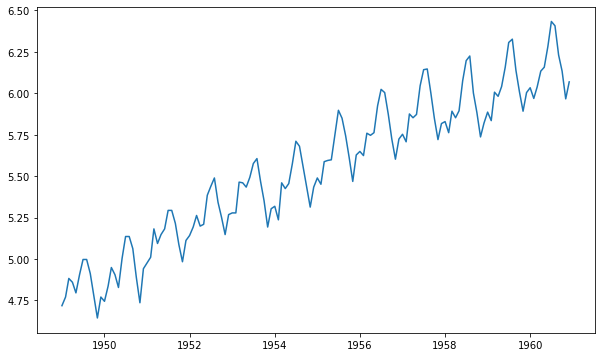

In [7]:
#Estimating trend
indexedDataset_logScale = np.log(indexedDataset)
plt.plot(indexedDataset_logScale)

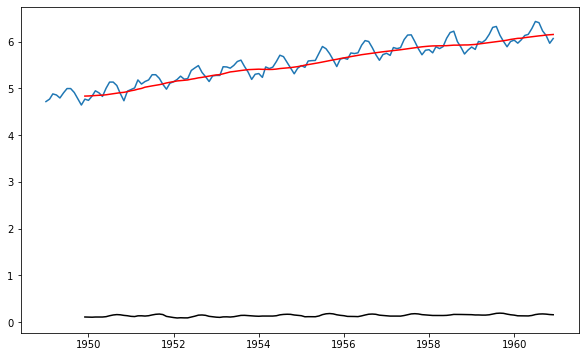

In [8]:
#The below transformation is required to make series stationary
movingAverage = indexedDataset_logScale.rolling(window=12).mean()
movingSTD = indexedDataset_logScale.rolling(window=12).std()
plt.plot(indexedDataset_logScale)
plt.plot(movingAverage, color='red')
plt.plot(movingSTD, color='black')

Mesmo após as transformações acima, a média móvel da série exponencialmente suavizada ainda apresenta tendência.<br>

O procedimento abaixo consiste em subtrair a série **movingAverage** (média móvel da série exponencialmente suavizada) da série **indexedDataset_logScale** série exponencialmente suavizada. <br>

Este truque é possível porque ambos apresentam tendência similar uma vez que foram originados da mesma série temporal. Verifique abaixo como efetuar o procedimento:

In [9]:
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head(12)

,Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN
1949-06-01,NaN
1949-07-01,NaN
1949-08-01,NaN
1949-09-01,NaN


In [10]:
#Remove NAN values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head(10)

,Passengers
Month,
1949-12-01,-0.065494
1950-01-01,-0.093449
1950-02-01,-0.007566
1950-03-01,0.099416
1950-04-01,0.052142
1950-05-01,-0.027529
1950-06-01,0.139881
1950-07-01,0.260184
1950-08-01,0.248635


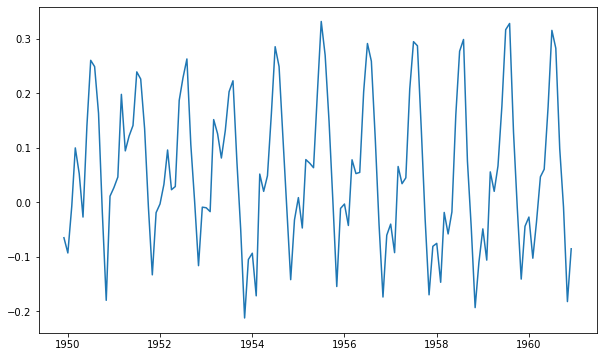

In [11]:
plt.plot(datasetLogScaleMinusMovingAverage)

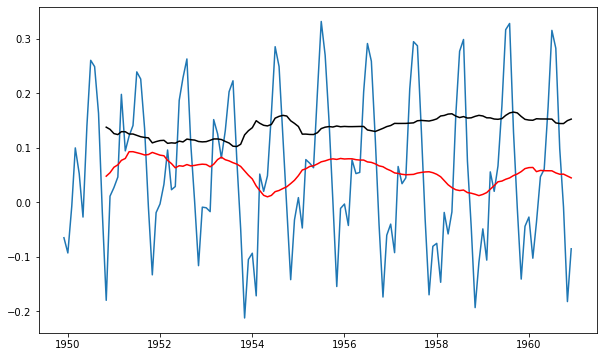

In [12]:
#The below transformation is required to make series stationary
movingAverage = datasetLogScaleMinusMovingAverage.rolling(window=12).mean()
movingSTD = datasetLogScaleMinusMovingAverage.rolling(window=12).std()
plt.plot(datasetLogScaleMinusMovingAverage)
plt.plot(movingAverage, color='red')
plt.plot(movingSTD, color='black')

In [13]:
#Perform Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(datasetLogScaleMinusMovingAverage['Passengers'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)    

Results of Dickey Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
Lags Used                       13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


Agora sim a média e variância da série alcancançaram a estacionariedade e podemos prosseguir para a estimativa dos hiperparâmetros do modelo ARIMA.

## Step 2. Estimativa dos hiperparâmetros

## Autocorrelation Function (ACF) e Partial Autocorrelation Function (PACF)

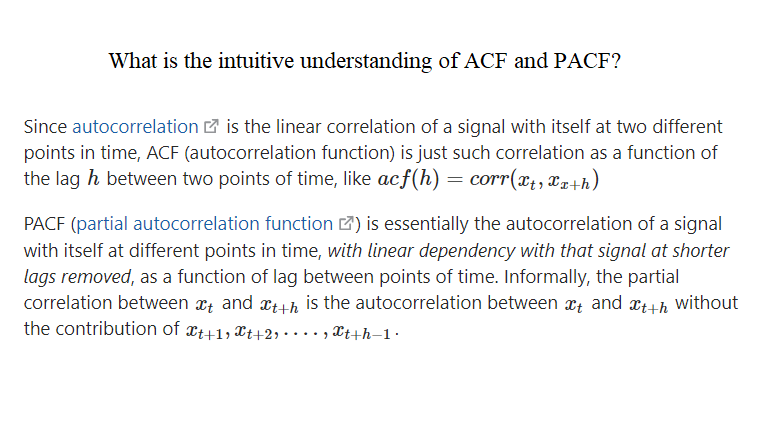

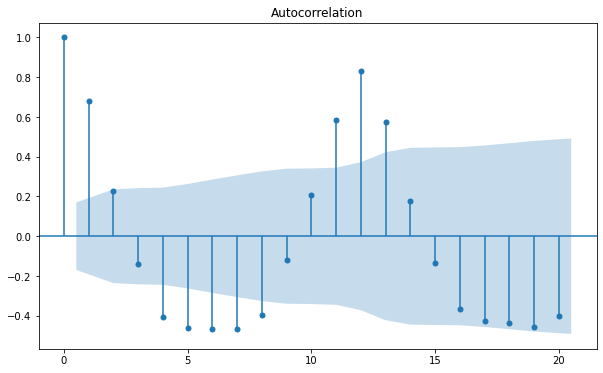

In [14]:
#Autocorrelação 
plot_acf(datasetLogScaleMinusMovingAverage, lags = 20)
plt.show()

Observe que a área sombreada em azul mais claro representa o intervalo de confiança de 95% (1.96 vezes o desvio padrão). <br>

**Para corroborar com a explicação intuitiva da ACF, perceba que à medida que o intervalo de tempo aumenta, o intervalo de confiança também tende à expansão. Isso porque o espaço amostral também aumenta.**

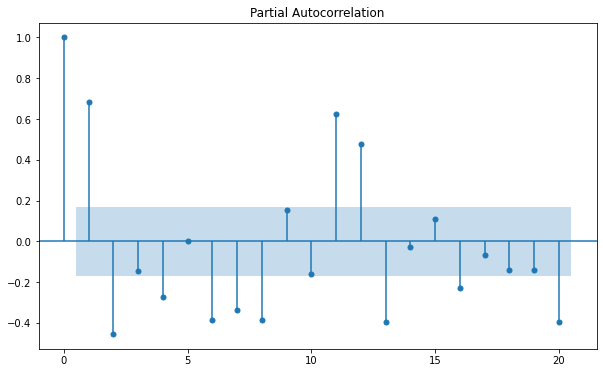

In [15]:
#Autocorrelação Parcial
plot_pacf(datasetLogScaleMinusMovingAverage, lags = 20)
plt.show()

**Para corroborar com a explicação intuitiva da PACF, perceba que à medida que o intervalo de tempo aumenta, o intervalo de confiança permanece constante. Isso ocorre porque o espaço amostral se mantém ao longo do tempo.**

## Akaike’s Information Criterion (AIC) e Bayesian Information Criterion (BIC)

Apesar dos gráficos acima nos trazerem uma perspectiva dos hiperparâmetros possíveis para o modelo, vamos aproveitar o tema para introduzir a função **auto_arima** em Python que utiliza as medidas de **AIC** e **BIC** para encontrar os melhores hiperparâmetros de maneira automática. <br>

Então **por que plotar ACF e PACF?** <br> A função abaixo demora um tanto para rodar. Os parâmetros abaixo indicam que a o teste será realizado iterando o valor dos parâmetros até o máximo definido na função:
<br>
**Exemplo:**

auto_arima(indexedDataset_logScale, start_p = 1, start_q = 1, <br>
                          **max_p** = 3, **max_q** = 3, **m** = 12,<br>
                          start_P = 0, seasonal = True,<br>
                          information_criterion='aic',<br>
                          d = None, D = 1, trace = True,<br>
                          error_action ='ignore',   <br>
                          suppress_warnings = True, <br>
                          stepwise = True)          <br>

Sendo que as iterações para o hiperparâmetro **p** vão de 1 a 3.<br>
As iterações para o hiperparâmetro **q** vão de 1 a 3.<br>
As iterações para o hiperparâmetro **m** (também chamado de 'd') vão de 1 a 12.<br>
<br>
**Quanto maior o hiperparâmetro maior o tempo de execução**.<br>

Dependendo do tamanho do seu dataset e dos hiperparâmetros necessários para ajuste do modelo, é possível que haja prejuízo de performance nos casos em que você precise testar **p**, **q** e **d** mais altos. Assim, o gráfico **ACF** e **PACF** já indicariam os valores mais razoáveis para os hiparâmetros mais rapidamente.<br>

**Observação**: espera-se que o valor de **d** esteja entre **0** e **2**. E que os parâmetros **p** e **q** sejam **próximos**, não ultrapassando **5**.

In [16]:
#Auto_Arima com teste por AIC
import warnings
warnings.filterwarnings("ignore")
  
# Fit auto_arima function to AirPassengers dataset
stepwise_fit = auto_arima(indexedDataset_logScale, start_p = 1, start_q = 1,
                          max_p = 3, max_q = 3, m = 12,
                          start_P = 0, seasonal = True,
                          information_criterion='aic',
                          d = None, D = 1, trace = True,
                          error_action ='ignore',   # we don't want to know if an order does not work
                          suppress_warnings = True,  # we don't want convergence warnings
                          stepwise = True)           # set to stepwise
  
# To print the summary
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=-489.188, Time=0.58 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-358.005, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-472.836, Time=0.42 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-423.080, Time=0.25 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-152.756, Time=0.02 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=-457.177, Time=0.11 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=-487.194, Time=0.47 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=-487.200, Time=0.68 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=-482.645, Time=0.53 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=-485.193, Time=1.57 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=-482.026, Time=0.54 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=-487.317, Time=1.20 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=-486.544, Time=1.30 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=-367.061, Time=0.25 sec
 ARIMA(0,0,2)(0,1,1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  144
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 12)   Log Likelihood                 249.647
Date:                              Wed, 23 Feb 2022   AIC                           -489.294
Time:                                      17:24:31   BIC                           -474.880
Sample:                                           0   HQIC                          -483.437
                                              - 144                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0191      0.008      2.314      0.021       0.003       0.035
ar.L1          0.5766      0.075      7.670      0.000       0.429       0.724
ar.L2          0.2623      0.084      3.131      0.002       0.098       0.426
ma.S.L12      -0.5554      0.106     -5.237      0.000      -0.763      -0.348
sigma2         0.0013      0.000      8.863      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 6.38
Prob(Q):                              0.89   Prob(JB):                         0.04
Heteroskedasticity (H):               0.58   Skew:                             0.07
Prob(H) (two-sided):                  0.07   Kurtosis:                         4.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
#Auto_Arima com teste por BIC
import warnings
warnings.filterwarnings("ignore")
  
# Fit auto_arima function to AirPassengers dataset
stepwise_fit = auto_arima(indexedDataset_logScale, start_p = 1, start_q = 1,
                          max_p = 3, max_q = 3, m = 12,
                          start_P = 0, seasonal = True,
                          information_criterion='bic',
                          d = None, D = 1, trace = True,
                          error_action ='ignore',   # we don't want to know if an order does not work
                          suppress_warnings = True,  # we don't want convergence warnings
                          stepwise = True)           # set to stepwise
  
# To print the summary
stepwise_fit.summary()

Performing stepwise search to minimize bic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : BIC=-474.774, Time=1.48 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : BIC=-352.240, Time=0.06 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : BIC=-461.305, Time=1.07 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : BIC=-411.549, Time=0.55 sec
 ARIMA(0,0,0)(0,1,0)[12]             : BIC=-149.873, Time=0.03 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : BIC=-445.646, Time=0.28 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : BIC=-469.898, Time=1.20 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : BIC=-469.903, Time=1.73 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : BIC=-468.231, Time=1.35 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : BIC=-465.013, Time=2.36 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : BIC=-470.495, Time=0.54 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : BIC=-470.020, Time=1.20 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : BIC=-469.247, Time=1.29 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : BIC=-358.413, Time=0.23 sec
 ARIMA(0,0,2)(0,1,1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  144
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 12)   Log Likelihood                 249.647
Date:                              Wed, 23 Feb 2022   AIC                           -489.294
Time:                                      17:24:56   BIC                           -474.880
Sample:                                           0   HQIC                          -483.437
                                              - 144                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0191      0.008      2.314      0.021       0.003       0.035
ar.L1          0.5766      0.075      7.670      0.000       0.429       0.724
ar.L2          0.2623      0.084      3.131      0.002       0.098       0.426
ma.S.L12      -0.5554      0.106     -5.237      0.000      -0.763      -0.348
sigma2         0.0013      0.000      8.863      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 6.38
Prob(Q):                              0.89   Prob(JB):                         0.04
Heteroskedasticity (H):               0.58   Skew:                             0.07
Prob(H) (two-sided):                  0.07   Kurtosis:                         4.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**RESULTADO:**

Nos dois testes o melhor modelo indicado é ARIMA(2,0,2)(2,1,0)[12], isto é, um modelo ARIMA com sazonalidade, também chamado de SARIMA:

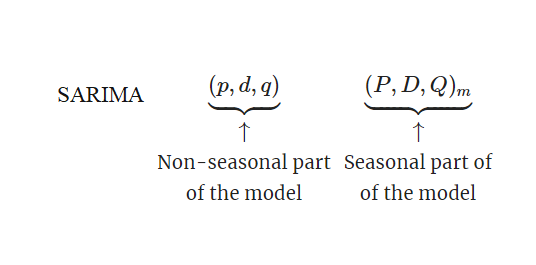

In [18]:
df = indexedDataset_logScale
train_data = df[1:len(df)-100]
test_data = df[len(df)-100:]

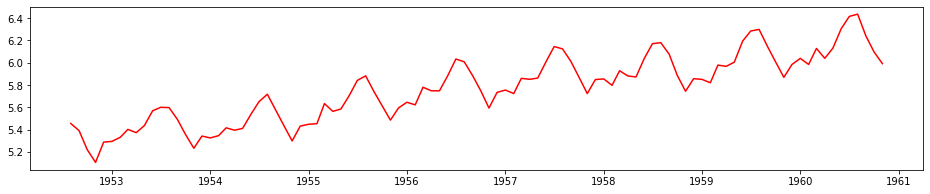

In [19]:
model = SARIMAX(df, order=(2,0, 0), seasonal_order= (0, 1, 1, 12))
model_fit = model.fit()
predictions = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data)-1)
plt.figure(figsize= (16, 3))
plt.plot(predictions, 'r-')
plt.show()

In [20]:
predictions = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data)-1)
predictions

1952-08-01    5.455005
1952-09-01    5.390053
1952-10-01    5.220235
1952-11-01    5.105655
1952-12-01    5.287545
                ...   
1960-07-01    6.415807
1960-08-01    6.436380
1960-09-01    6.238452
1960-10-01    6.097050
1960-11-01    5.991839
Freq: MS, Name: predicted_mean, Length: 100, dtype: float64

In [21]:
results = pd.merge(df, predictions, left_index=True, right_index=True)

In [22]:
results

,Passengers,predicted_mean
1952-08-01,5.488938,5.455005
1952-09-01,5.342334,5.390053
1952-10-01,5.252273,5.220235
1952-11-01,5.147494,5.105655
1952-12-01,5.267858,5.287545
...,...,...
1960-07-01,6.432940,6.415807
1960-08-01,6.406880,6.436380
1960-09-01,6.230481,6.238452
1960-10-01,6.133398,6.097050


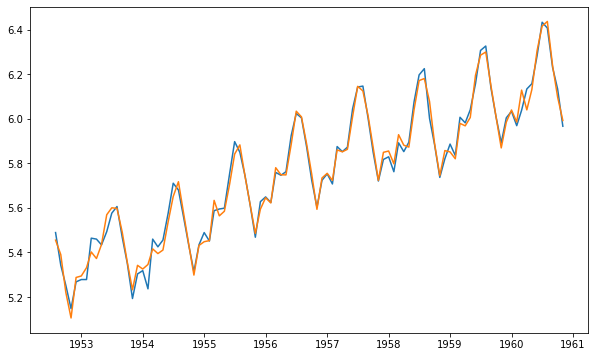

In [23]:
plt.plot(results)

## Step 3. Avaliação do Modelo

De maneira extremamente simplificada, apenas pela didática, vou calcular a correlação entre as séries primeiramente pelo coeficiente de Pearson:

In [24]:
results.corr()

,Passengers,predicted_mean
Passengers,1.000000,0.993407
predicted_mean,0.993407,1.000000


No entanto, são indicados os seguintes testes para avaliar correlação entre séries temporais: 
<br>
ME – Mean Error <br>
RMSE – Root Mean Squared Error <br>
MAE – Mean Absolute Error <br>
MPE – Mean Percentage Error  <br>
MAPE – Mean Absolute Percentage Error  <br>
ACF1 – Autocorrelation of errors at lag 1  <br>
Theil’s U – U Statistic  <br>

Abaixo vamos mensurar a acurácia do forecasting por MAPE:

In [25]:
#Defining MAPE function
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [26]:
from sklearn.metrics import mean_absolute_error
Y_actual = results['Passengers']
Y_Predicted = results['predicted_mean']
mape = mean_absolute_error(Y_actual, Y_Predicted)*100
print(mape)

2.687069292782443


O resultado do teste indica que entre os valores previstos e os ocorridos da série a diferença média é de 2,687%. <br>
Indicando que chegamos a um bom modelo!